# Document Encoder Model
- based on word2vec embeddings from gensim
- use a simple average of the word embeddings as the document embedding
- use a simple feedforward neural network as the encoder


In [37]:

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import gensim
import pandas as pd
import gensim.downloader as api
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence


In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.preprocess_str import preprocess_list as preprocess

[nltk_data] Downloading package stopwords to /Users/x25bd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/x25bd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
random_seed = 42  # You can choose any integer value
pd.set_option('mode.chained_assignment', None)  # Suppress SettingWithCopyWarning
np.random.seed(random_seed)

In [4]:
#PREPROCESS text8
raw_corpus = api.load('text8')

In [5]:
corpus = [preprocess(doc) for doc in raw_corpus]

In [6]:
w2v = gensim.models.Word2Vec(corpus, vector_size=100, window=5, min_count=3, workers=4)
w2v.save('./word2vec/word2vec-gensim-text8-custom-preprocess.model')

In [7]:
# Load the word2vec model, extract embeddings, convert to torch tensor
# w2v = gensim.models.Word2Vec.load('./word2vec/word2vec-gensim-text8-custom-preprocess.model')
vocab = w2v.wv.index_to_key
word_to_idx = {word: i for i, word in enumerate(vocab)}
embeddings_array = np.array([w2v.wv[word] for word in vocab])
embeddings = torch.tensor(embeddings_array, dtype=torch.float32)
print(embeddings.shape)

torch.Size([74792, 100])


In [10]:
embedding_layer = nn.Embedding.from_pretrained(embeddings, freeze=True)
word_index = torch.tensor([word_to_idx['north']], dtype=torch.long)


In [17]:
df = pd.read_parquet('../data/training.parquet')
df = df.sample(n=10000, random_state=random_seed)

In [18]:
df = df[['document', 'query', 'relevance']].copy()
df.reset_index(inplace=True)


In [21]:
def str_to_tokens(s):
    split = preprocess(s)
    return [word_to_idx[word] for word in split if word in word_to_idx]



In [22]:
df.loc[:, 'document_tokens'] = df['document'].apply(str_to_tokens)
df.loc[:, 'query_tokens'] = df['query'].apply(str_to_tokens)


In [24]:
df['query_length'] = df['query_tokens'].apply(len)
df['document_length'] = df['document_tokens'].apply(len)



SEQ_LENGTH: ~30


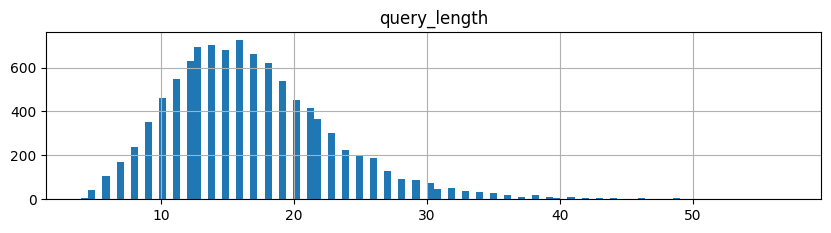

In [34]:
df[['query_length']].hist(bins=100, layout=(2,1 ), figsize=(10, 5))
print('SEQ_LENGTH: ~30')


In [53]:
def embed_tokens(tokens):
    embed_tensor = [torch.tensor(embedding_layer(torch.tensor(t, dtype=torch.long)), dtype=torch.float32) for t in tokens]
    embed_tensor = torch.stack(embed_tensor)
    return embed_tensor



In [38]:
class DocumentDataset(Dataset):
    def __init__(self, df_input):
        self.documents = df_input['document_tokens']
        self.queries = df_input['query_tokens']
        self.labels = df_input['relevance']

    def __len__(self):
        return len(self.documents)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.documents.iloc[idx], dtype=torch.long),
            torch.tensor(self.queries.iloc[idx], dtype=torch.long),
            torch.tensor(self.labels.iloc[idx], dtype=torch.float32),
        )



In [39]:
def collate(batch):
    docs, queries, labels = zip(*batch)
    docs = pad_sequence(docs, batch_first=True, padding_value=0)
    queries = pad_sequence(queries, batch_first=True, padding_value=0)

    # Create masks
    doc_mask = (docs != 0).float()
    query_mask = (queries != 0).float()
    labels = torch.tensor(labels, dtype=torch.float32)
    return docs, queries, doc_mask, query_mask, labels


train_dataset = DocumentDataset(df, df['relevance'])
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate)


In [40]:
df.loc[0, 'document_tokens']


(tensor([ 1133,    62,   222,   122,   270,   142,   222,    28,   270,    62,
           222, 30630,   308,   263,    62,    62,   222,   330,    72,    62,
           122,   543,   263,   263,   224,    62,   107,   222,    28,   270,
            62,   222,   122, 42359,    72,    62,   543,   122,   142,   107,
           543,   122,   308,    62,    72,   263,   122,    72,    62,   122,
           263,   330,    62,   142,    62,   543,   222,    62,    62,   222,
           107,   142,   263,    62,    28,   270,    62,   222,   122,    72,
           263,   122,   112,    62,   122,   122,   263,   330,    62,   543,
           222,   222,    28,   107, 42359,   142,   107,    72,   263,   122,
           112,    62,   112,    62,   122,    62,   543,   263,   330,    62,
           222,   112,   543,   222,   222,   122,   543,   263,   122,   122,
           122,    72,    62,    28,   270,    62,   222,   263,   107,   270,
           270,    62,   222, 30630,    72,    28,  

In [ ]:
df.loc[:, 'document_embeddings'] = df.loc[:, 'document_tokens'].apply(embed_tokens)
df.head()


In [ ]:
df[(df['query_length'] > 0) & (df['document_length'] > 0)]

In [ ]:
df.loc[:, 'query_embeddings'] = df.loc[:, 'query_tokens'].apply(embed_tokens)